## Fine Tuning

### This notebook will hold model iterations with the pre-trained Inception-ResNet-V2 

In [32]:
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
#Importing libraries for visualizations and analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

In [3]:
#Importing libraries for transfer learning and fine-tuning
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img

#Evaluation and preprocessing
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.python.keras import datasets, layers, models, regularizers


import glob
from tensorflow.keras.applications.imagenet_utils import preprocess_input, decode_predictions
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

#Transfer Model
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.layers import Input

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

import tensorflow_addons as tfa
from tensorflow_addons.layers import GroupNormalization

In [8]:
#Importing functions.py file containing functions for preprocessing and model evaluation
import src.functions as fn

#### Metrics to be used for all models

In [19]:
METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

#### Creating train, validation, and test datasets

In [9]:
transfer_train_data, transfer_val_data, transfer_test_data = fn.load_final_data_generators()

Found 2568 images belonging to 2 classes.
Found 550 images belonging to 2 classes.
Found 427 images belonging to 2 classes.


#### Validation data generated to evaluate the model using the test data from the cell above.

In [10]:
transfer_data_array, transfer_class_list = fn.generator_to_array(transfer_test_data)

#### Inception-ResNet-V2
- Out of the 4 pre-trained models we tried (ResNet-50, MobileNetV2, InceptionV3, InceptionResNetV2), InceptionResNetV2 performed the best without any fine-tuning. We are going to move forward with this model and see how much improvement can be made.

In [12]:
#Input dimensions for InceptionResNetV2
input_shape = Input(shape=(100,100,3))

#Instantiate InceptionResNetV2 including imagenet weights and cut the top off
base_model_inception_res = InceptionResNetV2(input_tensor=input_shape, include_top=False, weights='imagenet')

#Seeing how the model does without training any of the layers 
base_model_inception_res.trainable=False

#Checking the model configuration
base_model_inception_res.layers[-1].get_config()

{'name': 'conv_7b_ac',
 'trainable': False,
 'dtype': 'float32',
 'activation': 'relu'}

In [44]:
#Defining both train files to get a count on images in each class.
tr_train_files = glob.glob('../data/chest_xray/train/NORMAL/*'),  glob.glob('../data/chest_xray/train/PNEUMONIA/*')
tr_val_files = glob.glob('../data/chest_xray/val/NORMAL/*'),  glob.glob('../data/chest_xray/val/PNEUMONIA/*')

The cell below was a mistake where I didn't change the path for the files in tr_train_files, the weights produced from actually improved our model more than with the train files included.

In [42]:
tr_train_files = glob.glob('../data/chest_xray/val/NORMAL/*'),  glob.glob('../data/chest_xray/val/PNEUMONIA/*')
tr_val_files = glob.glob('../data/chest_xray/val/NORMAL/*'),  glob.glob('../data/chest_xray/val/PNEUMONIA/*')

#### Adding class weights to the model

In [43]:
class_weights = fn.get_class_weight(tr_train_files, tr_val_files)

{0: 1.3221153846153846, 1: 0.804093567251462}


##### Adding Exponential Decay to optimizer and decreasing the learning rate to see if there will be a performance increase

In [16]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.1,
                                                            decay_steps=20,
                                                            decay_rate=0.01)

#Exponential Decay with Stochastic Gradient Descent optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)


Instantiating Keras Sequential classifier with 2 layers and binary crossentropy as the loss function

In [20]:
inception_resnet2 = Sequential([base_model_inception_res,
                    tf.keras.layers.GlobalAveragePooling2D(),
                    tf.keras.layers.Dense(90, activation='relu'),
                    tf.keras.layers.Dense(1, activation='sigmoid')])

inception_resnet2.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=METRICS)

epochs = 20
batch_size=32

steps_per_epoch = transfer_train_data.n // batch_size

inception_resnet2_history = inception_resnet2.fit(transfer_train_data, class_weight=class_weight,
                  steps_per_epoch = steps_per_epoch,
                  epochs=epochs,
                  workers=4,
                  validation_data=transfer_val_data)

Epoch 1/20
80/80 [==============================] - 24s 304ms/step - loss: 0.6635 - accuracy: 0.7480 - precision: 0.7965 - recall: 0.7387 - val_loss: 0.4354 - val_accuracy: 0.8527 - val_precision: 0.9644 - val_recall: 0.7924
Epoch 2/20
80/80 [==============================] - 23s 285ms/step - loss: 0.5332 - accuracy: 0.7551 - precision: 0.7997 - recall: 0.7495 - val_loss: 0.4354 - val_accuracy: 0.8527 - val_precision: 0.9644 - val_recall: 0.7924
Epoch 3/20
80/80 [==============================] - 25s 315ms/step - loss: 0.5191 - accuracy: 0.7733 - precision: 0.8172 - recall: 0.7659 - val_loss: 0.4354 - val_accuracy: 0.8527 - val_precision: 0.9644 - val_recall: 0.7924
Epoch 4/20
80/80 [==============================] - 23s 292ms/step - loss: 0.5463 - accuracy: 0.7378 - precision: 0.7747 - recall: 0.7502 - val_loss: 0.4354 - val_accuracy: 0.8527 - val_precision: 0.9644 - val_recall: 0.7924
Epoch 5/20
80/80 [==============================] - 22s 270ms/step - loss: 0.5326 - accuracy: 0.7543

#### Results

              precision    recall  f1-score   support

      NORMAL       0.76      0.64      0.69       232
   PNEUMONIA       0.64      0.76      0.70       195

    accuracy                           0.70       427
   macro avg       0.70      0.70      0.70       427
weighted avg       0.71      0.70      0.70       427

Accurancy:  0.6955503512880562


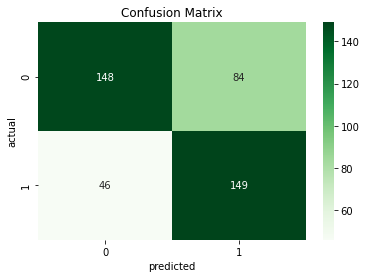

In [23]:
inception_resnet2_preds = inception_resnet2.predict_classes(transfer_data_array)
fn.evaluation(transfer_class_list, inception_resnet2_preds)

14/14 [==============================] - 5s 327ms/step - loss: 0.5827 - accuracy: 0.6956 - precision: 0.6395 - recall: 0.7641


[('loss', 0.5826970338821411),
 ('accuracy', 0.6955503225326538),
 ('precision', 0.6394850015640259),
 ('recall', 0.764102578163147)]

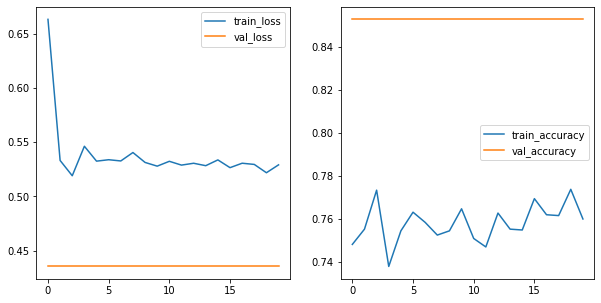

In [25]:
fn.plot_acc_loss(inception_resnet2, transfer_test_data, inception_resnet2_history)

Using the SGD optimizer did not improve our model's performance, I am going to stick with Adam as the optimizer

In [45]:
inception_resnet2.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=METRICS)

epochs = 20
batch_size=32

steps_per_epoch = transfer_train_data.n // batch_size

inception_resnet2_history = inception_resnet2.fit(transfer_train_data, class_weight=class_weight,
                  steps_per_epoch = steps_per_epoch,
                  epochs=epochs,
                  workers=4,
                  validation_data=transfer_val_data)

Epoch 1/20
80/80 [==============================] - 23s 287ms/step - loss: 0.2831 - accuracy: 0.8817 - precision: 0.8922 - recall: 0.8784 - val_loss: 0.1908 - val_accuracy: 0.9255 - val_precision: 0.9718 - val_recall: 0.9064
Epoch 2/20
80/80 [==============================] - 22s 273ms/step - loss: 0.2891 - accuracy: 0.8770 - precision: 0.9111 - recall: 0.8634 - val_loss: 0.1868 - val_accuracy: 0.9309 - val_precision: 0.9720 - val_recall: 0.9152
Epoch 3/20
80/80 [==============================] - 22s 274ms/step - loss: 0.2575 - accuracy: 0.8951 - precision: 0.9305 - recall: 0.8781 - val_loss: 0.1998 - val_accuracy: 0.9164 - val_precision: 0.9805 - val_recall: 0.8830
Epoch 4/20
80/80 [==============================] - 22s 276ms/step - loss: 0.2753 - accuracy: 0.8856 - precision: 0.9178 - recall: 0.8739 - val_loss: 0.2265 - val_accuracy: 0.9055 - val_precision: 0.9866 - val_recall: 0.8596
Epoch 5/20
80/80 [==============================] - 21s 261ms/step - loss: 0.2646 - accuracy: 0.8916

              precision    recall  f1-score   support

      NORMAL       0.92      0.84      0.88       232
   PNEUMONIA       0.83      0.91      0.87       195

    accuracy                           0.87       427
   macro avg       0.87      0.87      0.87       427
weighted avg       0.88      0.87      0.87       427

Accurancy:  0.8711943793911007


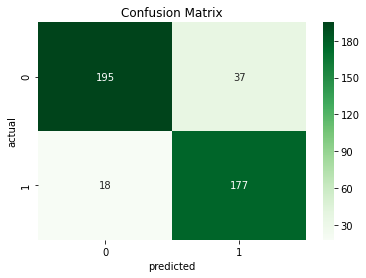

In [46]:
inception_resnet2_preds = inception_resnet2.predict_classes(transfer_data_array)
fn.evaluation(transfer_class_list, inception_resnet2_preds)

14/14 [==============================] - 5s 345ms/step - loss: 0.3900 - accuracy: 0.8712 - precision: 0.8271 - recall: 0.9077


[('loss', 0.3900466561317444),
 ('accuracy', 0.8711943626403809),
 ('precision', 0.827102780342102),
 ('recall', 0.9076923131942749)]

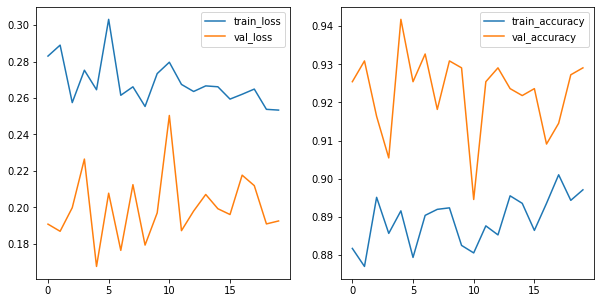

In [47]:
fn.plot_acc_loss(inception_resnet2, transfer_test_data, inception_resnet2_history)

Adding in the class weights with Adam as the optimizer produced better results. 

#### Fine tuning the model beginning with layer 750

In [49]:
base_model_inception_res.trainable = True
print('Number of layers in the base model: ', len(base_model_inception_res.layers))

fine_tune = 750
for layer in base_model_inception_res.layers[: fine_tune]:
    layer.trainable = False

Number of layers in the base model:  780


In [50]:
inception_resnet2.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=METRICS)

epochs = 20
batch_size=32

steps_per_epoch = transfer_train_data.n // batch_size

inception_resnet2_history = inception_resnet2.fit(transfer_train_data, class_weight=class_weight,
                  steps_per_epoch = steps_per_epoch,
                  epochs=epochs,
                  workers=4,
                  validation_data=transfer_val_data)

Epoch 1/20
80/80 [==============================] - 35s 443ms/step - loss: 0.4639 - accuracy: 0.8186 - precision: 0.8535 - recall: 0.8212 - val_loss: 0.3588 - val_accuracy: 0.8855 - val_precision: 0.9794 - val_recall: 0.8333
Epoch 2/20
80/80 [==============================] - 34s 424ms/step - loss: 0.3244 - accuracy: 0.8655 - precision: 0.8898 - recall: 0.8679 - val_loss: 0.6123 - val_accuracy: 0.8036 - val_precision: 0.9916 - val_recall: 0.6901
Epoch 3/20
80/80 [==============================] - 33s 417ms/step - loss: 0.2803 - accuracy: 0.8829 - precision: 0.9224 - recall: 0.8633 - val_loss: 0.3772 - val_accuracy: 0.8636 - val_precision: 0.9717 - val_recall: 0.8041
Epoch 4/20
80/80 [==============================] - 34s 423ms/step - loss: 0.2863 - accuracy: 0.8892 - precision: 0.9141 - recall: 0.8851 - val_loss: 0.2279 - val_accuracy: 0.9055 - val_precision: 0.9647 - val_recall: 0.8801
Epoch 5/20
80/80 [==============================] - 33s 416ms/step - loss: 0.2809 - accuracy: 0.8864

              precision    recall  f1-score   support

      NORMAL       0.95      0.81      0.88       232
   PNEUMONIA       0.81      0.95      0.87       195

    accuracy                           0.88       427
   macro avg       0.88      0.88      0.88       427
weighted avg       0.89      0.88      0.88       427

Accurancy:  0.8758782201405152


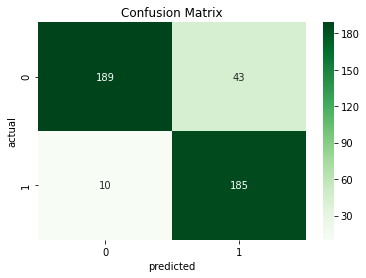

In [51]:
inception_resnet2_preds = inception_resnet2.predict_classes(transfer_data_array)
fn.evaluation(transfer_class_list, inception_resnet2_preds)

14/14 [==============================] - 5s 369ms/step - loss: 0.3751 - accuracy: 0.8759 - precision: 0.8114 - recall: 0.9487


[('loss', 0.37506821751594543),
 ('accuracy', 0.8758782148361206),
 ('precision', 0.8114035129547119),
 ('recall', 0.9487179517745972)]

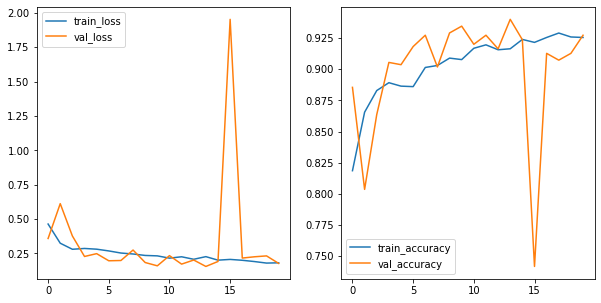

In [52]:
fn.plot_acc_loss(inception_resnet2, transfer_test_data, inception_resnet2_history)

Trying early stopping parameter with patience level of 13 and monitoring loss

In [160]:
c_back = tf.keras.callbacks.EarlyStopping(patience=13, restore_best_weights=True)

In [128]:
inception_resnet2.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=METRICS)

epochs = 50
batch_size=32

steps_per_epoch = transfer_train_data.n // batch_size

inception_resnet2_history = inception_resnet2.fit(transfer_train_data, class_weight=class_weight,
                  steps_per_epoch = steps_per_epoch,
                  epochs=epochs,
                  workers=4,
                  callbacks=c_back,
                  validation_data=transfer_val_data)

Epoch 1/50
80/80 [==============================] - 37s 460ms/step - loss: 0.1589 - accuracy: 0.9405 - precision: 0.9445 - recall: 0.9316 - val_loss: 0.2201 - val_accuracy: 0.9273 - val_precision: 0.9748 - val_recall: 0.9064
Epoch 2/50
80/80 [==============================] - 35s 434ms/step - loss: 0.1600 - accuracy: 0.9416 - precision: 0.9677 - recall: 0.9269 - val_loss: 0.1902 - val_accuracy: 0.9291 - val_precision: 0.9605 - val_recall: 0.9240
Epoch 3/50
80/80 [==============================] - 38s 474ms/step - loss: 0.1591 - accuracy: 0.9393 - precision: 0.9619 - recall: 0.9280 - val_loss: 0.2304 - val_accuracy: 0.9273 - val_precision: 0.9548 - val_recall: 0.9269
Epoch 4/50
80/80 [==============================] - 38s 470ms/step - loss: 0.1462 - accuracy: 0.9436 - precision: 0.9576 - recall: 0.9408 - val_loss: 0.1692 - val_accuracy: 0.9418 - val_precision: 0.9697 - val_recall: 0.9357
Epoch 5/50
80/80 [==============================] - 37s 463ms/step - loss: 0.1425 - accuracy: 0.9472

              precision    recall  f1-score   support

      NORMAL       0.95      0.84      0.89       232
   PNEUMONIA       0.84      0.94      0.89       195

    accuracy                           0.89       427
   macro avg       0.89      0.89      0.89       427
weighted avg       0.90      0.89      0.89       427

Accurancy:  0.8899297423887588


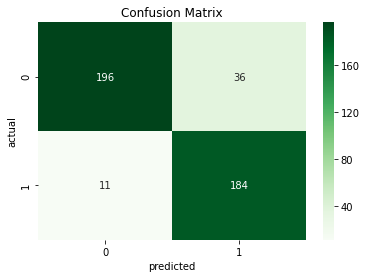

14/14 [==============================] - 5s 356ms/step - loss: 0.3626 - accuracy: 0.8899 - precision: 0.8364 - recall: 0.9436


[('loss', 0.36264967918395996),
 ('accuracy', 0.8899297714233398),
 ('precision', 0.8363636136054993),
 ('recall', 0.9435897469520569)]

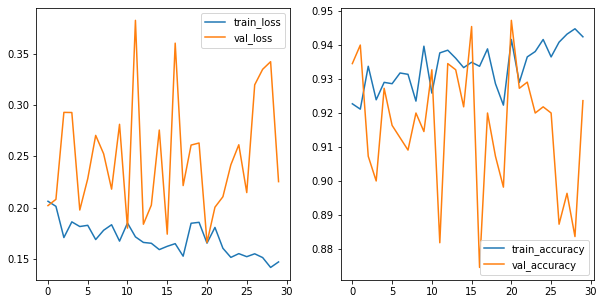

In [97]:

inception_resnet2_preds = inception_resnet2.predict_classes(transfer_data_array)
evaluation(transfer_class_list, inception_resnet2_preds)

train_loss = inception_resnet2_history.history['loss']
train_acc = inception_resnet2_history.history['accuracy']
val_loss = inception_resnet2_history.history['val_loss']
val_acc = inception_resnet2_history.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
sns.lineplot(inception_resnet2_history.epoch, train_loss, ax=ax1, label='train_loss')
sns.lineplot(inception_resnet2_history.epoch, train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(inception_resnet2_history.epoch, val_loss, ax=ax1, label='val_loss')
sns.lineplot(inception_resnet2_history.epoch, val_acc, ax=ax2, label='val_accuracy')

acc = inception_resnet2.evaluate_generator(transfer_test_data, steps=len(transfer_test_data), verbose=1)
list(zip(inception_resnet2.metrics_names, acc))

In [102]:
mets = list(zip(inception_resnet2.metrics_names, acc))

In [116]:
from sklearn.metrics import roc_curve, auc

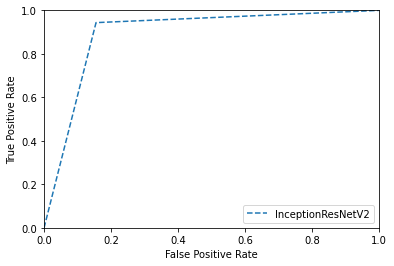

In [126]:
fpr, tpr, thresholds = roc_curve(transfer_class_list, inception_resnet2_preds)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, linestyle='--', label='InceptionResNetV2')
#plt.plot(fpr, tpr, marker='.')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim(0,1, 20)
plt.ylim(0,1,30)
# show the legend
plt.legend()
# show the plot
plt.show()

In [127]:
roc_auc

0.8942086648983201

#### Fine tuning the model beginning with layer 600

In [133]:
base_model_inception_res.trainable = True
print('Number of layers in the base model: ', len(base_model_inception_res.layers))

fine_tune = 600
for layer in base_model_inception_res.layers[: fine_tune]:
    layer.trainable = False

Number of layers in the base model:  780


In [138]:
inception_resnet2.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=METRICS)

epochs = 50
batch_size=32

steps_per_epoch = transfer_train_data.n // batch_size

inception_resnet2_history = inception_resnet2.fit(transfer_train_data, class_weight=class_weight,
                  steps_per_epoch = steps_per_epoch,
                  epochs=epochs,
                  workers=4,
                  callbacks=c_back,
                  validation_data=transfer_val_data)

Epoch 1/50
80/80 [==============================] - 43s 540ms/step - loss: 0.2044 - accuracy: 0.9203 - precision: 0.9330 - recall: 0.9300 - val_loss: 1.8418 - val_accuracy: 0.9491 - val_precision: 0.9816 - val_recall: 0.9357
Epoch 2/50
80/80 [==============================] - 41s 519ms/step - loss: 0.1628 - accuracy: 0.9322 - precision: 0.9476 - recall: 0.9303 - val_loss: 0.2431 - val_accuracy: 0.9127 - val_precision: 0.9868 - val_recall: 0.8713
Epoch 3/50
80/80 [==============================] - 42s 528ms/step - loss: 0.1770 - accuracy: 0.9298 - precision: 0.9395 - recall: 0.9342 - val_loss: 0.2322 - val_accuracy: 0.9000 - val_precision: 0.9898 - val_recall: 0.8480
Epoch 4/50
80/80 [==============================] - 44s 548ms/step - loss: 0.1919 - accuracy: 0.9243 - precision: 0.9310 - recall: 0.9337 - val_loss: 0.1837 - val_accuracy: 0.9400 - val_precision: 0.9874 - val_recall: 0.9152
Epoch 5/50
80/80 [==============================] - 42s 526ms/step - loss: 0.1895 - accuracy: 0.9105

              precision    recall  f1-score   support

      NORMAL       0.96      0.88      0.91       232
   PNEUMONIA       0.87      0.95      0.91       195

    accuracy                           0.91       427
   macro avg       0.91      0.91      0.91       427
weighted avg       0.92      0.91      0.91       427

Accurancy:  0.9110070257611241


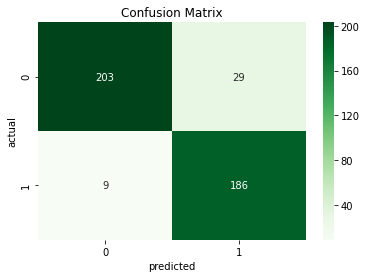

14/14 [==============================] - 5s 391ms/step - loss: 0.2780 - accuracy: 0.9110 - precision: 0.8651 - recall: 0.9538


[('loss', 0.2779882550239563),
 ('accuracy', 0.9110070466995239),
 ('precision', 0.8651162981987),
 ('recall', 0.9538461565971375)]

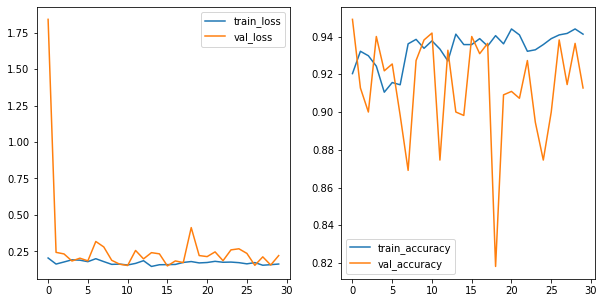

In [140]:
inception_resnet2_preds = inception_resnet2.predict_classes(transfer_data_array)
evaluation(transfer_class_list, inception_resnet2_preds)

train_loss = inception_resnet2_history.history['loss']
train_acc = inception_resnet2_history.history['accuracy']
val_loss = inception_resnet2_history.history['val_loss']
val_acc = inception_resnet2_history.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
sns.lineplot(inception_resnet2_history.epoch, train_loss, ax=ax1, label='train_loss')
sns.lineplot(inception_resnet2_history.epoch, train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(inception_resnet2_history.epoch, val_loss, ax=ax1, label='val_loss')
sns.lineplot(inception_resnet2_history.epoch, val_acc, ax=ax2, label='val_accuracy')

acc = inception_resnet2.evaluate_generator(transfer_test_data, steps=len(transfer_test_data), verbose=1)
list(zip(inception_resnet2.metrics_names, acc))

#### Adding early callback to focus on recall score

In [141]:
c_back = tf.keras.callbacks.EarlyStopping(patience=16, restore_best_weights=True, monitor='recall')

In [142]:
inception_resnet2.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=METRICS)

epochs = 50
batch_size=32

steps_per_epoch = transfer_train_data.n // batch_size

inception_resnet2_history = inception_resnet2.fit(transfer_train_data, class_weight=class_weight,
                  steps_per_epoch = steps_per_epoch,
                  epochs=epochs,
                  workers=4,
                  callbacks=c_back,
                  validation_data=transfer_val_data)

Epoch 1/50
80/80 [==============================] - 43s 535ms/step - loss: 0.1733 - accuracy: 0.9267 - precision: 0.9560 - recall: 0.9027 - val_loss: 0.3019 - val_accuracy: 0.8636 - val_precision: 1.0000 - val_recall: 0.7807
Epoch 2/50
80/80 [==============================] - 41s 518ms/step - loss: 0.1701 - accuracy: 0.9251 - precision: 0.9637 - recall: 0.8998 - val_loss: 0.2379 - val_accuracy: 0.8964 - val_precision: 1.0000 - val_recall: 0.8333
Epoch 3/50
80/80 [==============================] - 42s 523ms/step - loss: 0.1640 - accuracy: 0.9361 - precision: 0.9673 - recall: 0.9169 - val_loss: 0.1518 - val_accuracy: 0.9491 - val_precision: 0.9906 - val_recall: 0.9269
Epoch 4/50
80/80 [==============================] - 43s 532ms/step - loss: 0.1639 - accuracy: 0.9409 - precision: 0.9681 - recall: 0.9243 - val_loss: 0.1829 - val_accuracy: 0.9309 - val_precision: 0.9935 - val_recall: 0.8947
Epoch 5/50
80/80 [==============================] - 42s 530ms/step - loss: 0.1739 - accuracy: 0.9353

              precision    recall  f1-score   support

      NORMAL       0.91      0.90      0.90       232
   PNEUMONIA       0.88      0.89      0.89       195

    accuracy                           0.89       427
   macro avg       0.89      0.89      0.89       427
weighted avg       0.89      0.89      0.89       427

Accurancy:  0.8946135831381733


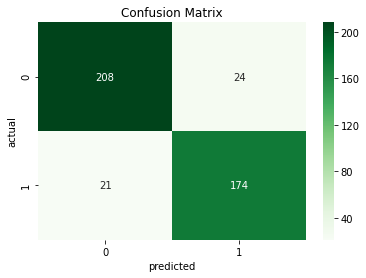

14/14 [==============================] - 5s 374ms/step - loss: 0.4218 - accuracy: 0.8946 - precision: 0.8788 - recall: 0.8923


[('loss', 0.42184752225875854),
 ('accuracy', 0.8946135640144348),
 ('precision', 0.8787878751754761),
 ('recall', 0.892307698726654)]

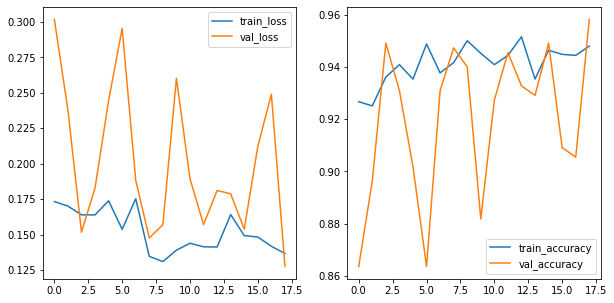

In [143]:
inception_resnet2_preds = inception_resnet2.predict_classes(transfer_data_array)
evaluation(transfer_class_list, inception_resnet2_preds)

train_loss = inception_resnet2_history.history['loss']
train_acc = inception_resnet2_history.history['accuracy']
val_loss = inception_resnet2_history.history['val_loss']
val_acc = inception_resnet2_history.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
sns.lineplot(inception_resnet2_history.epoch, train_loss, ax=ax1, label='train_loss')
sns.lineplot(inception_resnet2_history.epoch, train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(inception_resnet2_history.epoch, val_loss, ax=ax1, label='val_loss')
sns.lineplot(inception_resnet2_history.epoch, val_acc, ax=ax2, label='val_accuracy')

acc = inception_resnet2.evaluate_generator(transfer_test_data, steps=len(transfer_test_data), verbose=1)
list(zip(inception_resnet2.metrics_names, acc))

#### Fine Tuning iteration from layer 635

In [144]:
base_model_inception_res.trainable = True
print('Number of layers in the base model: ', len(base_model_inception_res.layers))

fine_tune = 635
for layer in base_model_inception_res.layers[: fine_tune]:
    layer.trainable = False

Number of layers in the base model:  780


In [145]:
c_back = tf.keras.callbacks.EarlyStopping(patience=16, restore_best_weights=True)

In [146]:
inception_resnet2.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=METRICS)

epochs = 50
batch_size=32

steps_per_epoch = transfer_train_data.n // batch_size

inception_resnet2_history = inception_resnet2.fit(transfer_train_data, class_weight=class_weight,
                  steps_per_epoch = steps_per_epoch,
                  epochs=epochs,
                  workers=4,
                  callbacks=c_back,
                  validation_data=transfer_val_data)

Epoch 1/50
80/80 [==============================] - 42s 520ms/step - loss: 0.1680 - accuracy: 0.9314 - precision: 0.9604 - recall: 0.9015 - val_loss: 0.1686 - val_accuracy: 0.9345 - val_precision: 0.9935 - val_recall: 0.9006
Epoch 2/50
80/80 [==============================] - 40s 496ms/step - loss: 0.1687 - accuracy: 0.9326 - precision: 0.9636 - recall: 0.9141 - val_loss: 0.2215 - val_accuracy: 0.9091 - val_precision: 0.9966 - val_recall: 0.8567
Epoch 3/50
80/80 [==============================] - 41s 515ms/step - loss: 0.1719 - accuracy: 0.9345 - precision: 0.9624 - recall: 0.9191 - val_loss: 0.2054 - val_accuracy: 0.9273 - val_precision: 0.9935 - val_recall: 0.8889
Epoch 4/50
80/80 [==============================] - 41s 510ms/step - loss: 0.1506 - accuracy: 0.9412 - precision: 0.9681 - recall: 0.9250 - val_loss: 0.1730 - val_accuracy: 0.9491 - val_precision: 0.9876 - val_recall: 0.9298
Epoch 5/50
80/80 [==============================] - 41s 507ms/step - loss: 0.1901 - accuracy: 0.9164

              precision    recall  f1-score   support

      NORMAL       0.96      0.84      0.90       232
   PNEUMONIA       0.83      0.96      0.89       195

    accuracy                           0.89       427
   macro avg       0.90      0.90      0.89       427
weighted avg       0.90      0.89      0.89       427

Accurancy:  0.8946135831381733


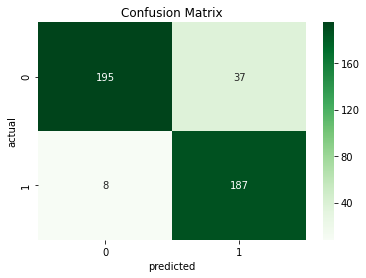

14/14 [==============================] - 5s 378ms/step - loss: 0.2944 - accuracy: 0.8946 - precision: 0.8348 - recall: 0.9590


[('loss', 0.29443687200546265),
 ('accuracy', 0.8946135640144348),
 ('precision', 0.8348214030265808),
 ('recall', 0.9589743614196777)]

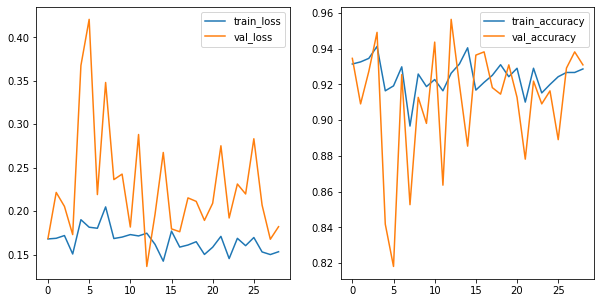

In [147]:
inception_resnet2_preds = inception_resnet2.predict_classes(transfer_data_array)
evaluation(transfer_class_list, inception_resnet2_preds)

train_loss = inception_resnet2_history.history['loss']
train_acc = inception_resnet2_history.history['accuracy']
val_loss = inception_resnet2_history.history['val_loss']
val_acc = inception_resnet2_history.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
sns.lineplot(inception_resnet2_history.epoch, train_loss, ax=ax1, label='train_loss')
sns.lineplot(inception_resnet2_history.epoch, train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(inception_resnet2_history.epoch, val_loss, ax=ax1, label='val_loss')
sns.lineplot(inception_resnet2_history.epoch, val_acc, ax=ax2, label='val_accuracy')

acc = inception_resnet2.evaluate_generator(transfer_test_data, steps=len(transfer_test_data), verbose=1)
list(zip(inception_resnet2.metrics_names, acc))

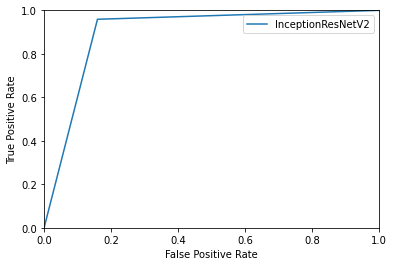

0.8997458001768347


In [149]:
fpr, tpr, thresholds = roc_curve(transfer_class_list, inception_resnet2_preds)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, linestyle='-', label='InceptionResNetV2')
#plt.plot(fpr, tpr, marker='.')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim(0,1, 20)
plt.ylim(0,1,30)
# show the legend
plt.legend()
# show the plot
plt.show()
print(roc_auc)

In [161]:
base_model_inception_res.trainable = True
print('Number of layers in the base model: ', len(base_model_inception_res.layers))

fine_tune = 600
for layer in base_model_inception_res.layers[: fine_tune]:
    layer.trainable = False

Number of layers in the base model:  780


In [202]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model', save_best_only=True)
c_back = tf.keras.callbacks.EarlyStopping(patience=12, restore_best_weights=True)

In [205]:
inception_resnet2.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=METRICS)

epochs = 20
batch_size=32

steps_per_epoch = transfer_train_data.n // batch_size

inception_resnet2_history = inception_resnet2.fit(transfer_train_data, class_weight=class_weight,
                  steps_per_epoch = steps_per_epoch,
                  epochs=epochs,
                  workers=4,
                  validation_data=transfer_val_data)

Epoch 1/20
80/80 [==============================] - 48s 604ms/step - loss: 0.1136 - accuracy: 0.9578 - precision: 0.9748 - recall: 0.9438 - val_loss: 0.1670 - val_accuracy: 0.9382 - val_precision: 0.9904 - val_recall: 0.9094
Epoch 2/20
80/80 [==============================] - 47s 587ms/step - loss: 0.1219 - accuracy: 0.9610 - precision: 0.9761 - recall: 0.9534 - val_loss: 0.1447 - val_accuracy: 0.9473 - val_precision: 0.9906 - val_recall: 0.9240
Epoch 3/20
80/80 [==============================] - 47s 592ms/step - loss: 0.1184 - accuracy: 0.9578 - precision: 0.9746 - recall: 0.9492 - val_loss: 0.2094 - val_accuracy: 0.9200 - val_precision: 0.9901 - val_recall: 0.8801
Epoch 4/20
80/80 [==============================] - 47s 588ms/step - loss: 0.1150 - accuracy: 0.9554 - precision: 0.9725 - recall: 0.9471 - val_loss: 0.1673 - val_accuracy: 0.9345 - val_precision: 0.9935 - val_recall: 0.9006
Epoch 5/20
80/80 [==============================] - 48s 595ms/step - loss: 0.1013 - accuracy: 0.9618

              precision    recall  f1-score   support

      NORMAL       0.97      0.85      0.91       232
   PNEUMONIA       0.85      0.96      0.90       195

    accuracy                           0.90       427
   macro avg       0.91      0.91      0.90       427
weighted avg       0.91      0.90      0.90       427

Recall:  0.9641025641025641


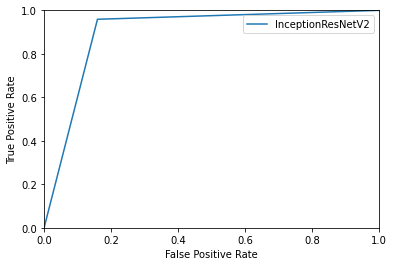

ROC-AUC: 0.8997458001768347


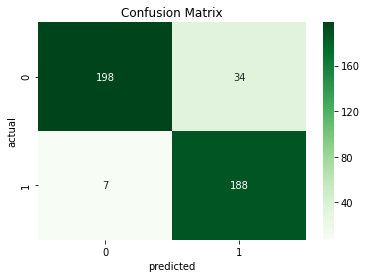

14/14 [==============================] - 5s 386ms/step - loss: 0.2996 - accuracy: 0.9040 - precision: 0.8468 - recall: 0.9641


[('loss', 0.2995607852935791),
 ('accuracy', 0.9039812684059143),
 ('precision', 0.8468468189239502),
 ('recall', 0.964102566242218)]

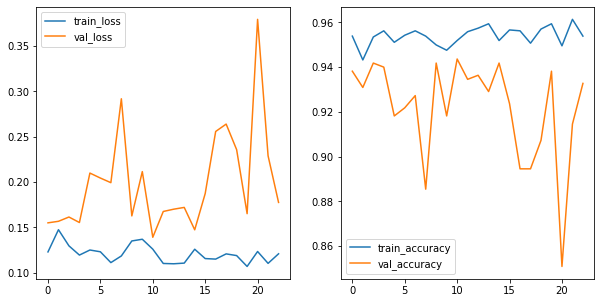

In [182]:
inception_resnet2_preds = inception_resnet2.predict_classes(transfer_data_array)
evaluation(transfer_class_list, inception_resnet2_preds)

train_loss = inception_resnet2_history.history['loss']
train_acc = inception_resnet2_history.history['accuracy']
val_loss = inception_resnet2_history.history['val_loss']
val_acc = inception_resnet2_history.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
sns.lineplot(inception_resnet2_history.epoch, train_loss, ax=ax1, label='train_loss')
sns.lineplot(inception_resnet2_history.epoch, train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(inception_resnet2_history.epoch, val_loss, ax=ax1, label='val_loss')
sns.lineplot(inception_resnet2_history.epoch, val_acc, ax=ax2, label='val_accuracy')

acc = inception_resnet2.evaluate_generator(transfer_test_data, steps=len(transfer_test_data), verbose=1)
list(zip(inception_resnet2.metrics_names, acc))

#### Same model but increasing shear and zoom range for training images

In [194]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./225,
                                                               shear_range=0.3,
                                                               zoom_range=0.4,
                                                               horizontal_flip=True)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./225)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./225)
transfer_train_data = train_datagen.flow_from_directory('../data/chest_xray2/train_2/',
                                               target_size=(100,100),
                                               batch_size=32,
                                               class_mode='binary')
transfer_val_data = val_datagen.flow_from_directory('../data/chest_xray2/val/',
                                               target_size=(100,100),
                                               batch_size=32,
                                               class_mode='binary')
transfer_test_data = test_datagen.flow_from_directory('../data/chest_xray/test/',
                                             target_size=(100,100),
                                             batch_size=32,
                                             class_mode='binary')

Found 2568 images belonging to 2 classes.
Found 550 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [195]:
transfer_first_batch = transfer_test_data.next()
transfer_data_list = transfer_first_batch[0]
batch_index = 0
transfer_class_list = transfer_first_batch[1]
while batch_index <= transfer_test_data.batch_index:
    transfer_data = transfer_test_data.next()
    #print(data[0].shape)
    transfer_data_list=np.concatenate((transfer_data_list, transfer_data[0]))
    transfer_class_list=np.concatenate((transfer_class_list, transfer_data[1]))
    batch_index = batch_index + 1
transfer_data_array = np.asarray(transfer_data_list)
transfer_data_array.shape

(624, 100, 100, 3)

              precision    recall  f1-score   support

      NORMAL       0.95      0.85      0.90       234
   PNEUMONIA       0.92      0.97      0.95       390

    accuracy                           0.93       624
   macro avg       0.94      0.91      0.92       624
weighted avg       0.93      0.93      0.93       624

Recall:  0.9743589743589743


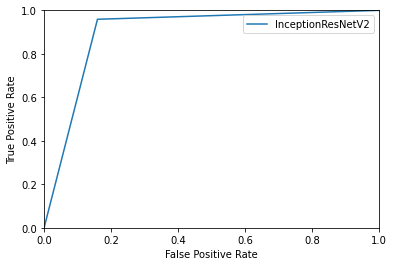

ROC-AUC: 0.8997458001768347


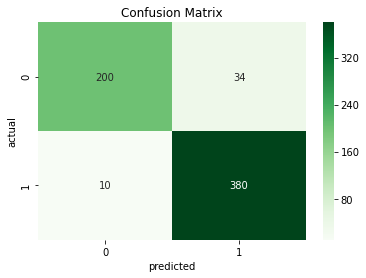

20/20 [==============================] - 6s 318ms/step - loss: 0.2197 - accuracy: 0.9295 - precision: 0.9179 - recall: 0.9744


[('loss', 0.21972163021564484),
 ('accuracy', 0.9294871687889099),
 ('precision', 0.9178743958473206),
 ('recall', 0.9743589758872986)]

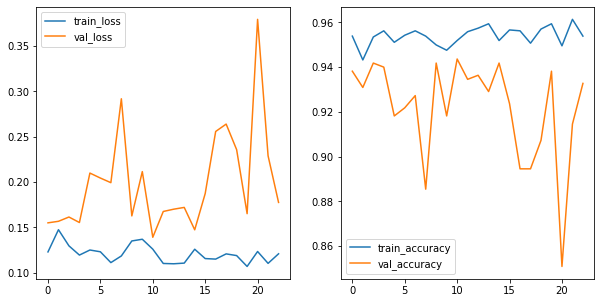

In [196]:
inception_resnet2_preds = inception_resnet2.predict_classes(transfer_data_array)
evaluation(transfer_class_list, inception_resnet2_preds)

train_loss = inception_resnet2_history.history['loss']
train_acc = inception_resnet2_history.history['accuracy']
val_loss = inception_resnet2_history.history['val_loss']
val_acc = inception_resnet2_history.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
sns.lineplot(inception_resnet2_history.epoch, train_loss, ax=ax1, label='train_loss')
sns.lineplot(inception_resnet2_history.epoch, train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(inception_resnet2_history.epoch, val_loss, ax=ax1, label='val_loss')
sns.lineplot(inception_resnet2_history.epoch, val_acc, ax=ax2, label='val_accuracy')

acc = inception_resnet2.evaluate_generator(transfer_test_data, steps=len(transfer_test_data), verbose=1)
list(zip(inception_resnet2.metrics_names, acc))